# SMS Spam Classification with Logistic Regression
## Author: Carine Ashimwe

This notebook implements a logistic regression model for SMS spam classification using the SMS Spam Collection dataset from UCI. The approach includes comprehensive data preprocessing, feature engineering with TF-IDF embeddings, hyperparameter tuning, and thorough evaluation with multiple metrics and visualizations.

## 1. Import Libraries and Setup

In [29]:
# Import essential libraries
import os
import re
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           f1_score, precision_score, recall_score, roc_auc_score, roc_curve, log_loss)
from scipy import sparse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# NLTK setup for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [30]:
# Setup NLTK components and Google Drive (if using Colab)
def _ensure_nltk():
    """Download required NLTK data if not present"""
    try:
        _ = stopwords.words("english")
    except LookupError:
        print("Downloading stopwords...")
        nltk.download("stopwords")
    try:
        _ = nltk.data.find("corpora/wordnet")
    except LookupError:
        print("Downloading wordnet...")
        nltk.download("wordnet")
    try:
        _ = nltk.data.find("tokenizers/punkt")
    except LookupError:
        print("Downloading punkt...")
        nltk.download("punkt")

def _mount_gdrive_if_needed():
    """Mount Google Drive if running in Google Colab"""
    try:
        from google.colab import drive
        try:
            drive.mount('/mydrive', force_remount=False)
            print(" Google Drive mounted successfully at /mydrive")
        except:
            print(" Google Drive already mounted")
    except ImportError:
        # Not running in Colab, skip mounting
        print("ℹ Not running in Google Colab - skipping Drive mount")

_ensure_nltk()
_mount_gdrive_if_needed()

STOP_WORDS = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()

print(" NLTK setup completed!")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Mounted at /mydrive
 Google Drive mounted successfully at /mydrive
 NLTK setup completed!


## 2. Data Loading and Preprocessing Functions

In [31]:
def load_dataset():
    """Load the SMS Spam Collection dataset from Google Drive or local path"""
    # Priority 1: Check Google Drive paths first
    drive_candidates = [
        "/mydrive/sms+spam+collection/SMSSpamCollection",
        "/mydrive/sms+spam+collection/SMSSpamCollection.txt",
        "/mydrive/sms+spam+collection/SMSSpamCollection.csv",
        "/content/drive/MyDrive/sms+spam+collection/SMSSpamCollection",
        "/content/drive/MyDrive/sms+spam+collection/SMSSpamCollection.txt",
        "/content/drive/MyDrive/sms+spam+collection/SMSSpamCollection.csv",
    ]

    # Priority 2: Check local and content paths
    local_candidates = [
        "SMSSpamCollection.txt",
        "SMSSpamCollection.csv",
        "SMSSpamCollection",
        "spam.csv",
        os.path.join("content", "SMSSpamCollection.txt"),
        os.path.join("content", "SMSSpamCollection.csv"),
        os.path.join("content", "SMSSpamCollection"),
        os.path.join("content", "spam.csv"),
    ]

    all_candidates = drive_candidates + local_candidates

    for path in all_candidates:
        # Check both with and without extensions
        paths_to_try = [path]
        if not path.endswith(('.txt', '.csv')):
            paths_to_try.extend([path + '.txt', path + '.csv'])

        for try_path in paths_to_try:
            if os.path.exists(try_path):
                print(f"📁 Loading dataset: {try_path}")
                # SMS Spam Collection format: label\tmessage
                if try_path.endswith('.txt'):
                    df = pd.read_csv(try_path, sep='\t', header=None, names=['label', 'text'])
                else:
                    # For CSV, try to auto-detect and handle different formats
                    try:
                        df = pd.read_csv(try_path, sep='\t', header=None, names=['label', 'text'])
                    except:
                        df = pd.read_csv(try_path, encoding='latin-1')
                        # Handle case where CSV has headers
                        if 'label' not in df.columns and len(df.columns) >= 2:
                            df.columns = ['label', 'text'] + list(df.columns[2:])
                return df, try_path

    raise FileNotFoundError(
        " SMS Spam dataset not found!\n"
        "   Expected locations:\n"
        "   1. /mydrive/sms+spam+collection/SMSSpamCollection (any extension)\n"
        "   2. /content/drive/MyDrive/sms+spam+collection/SMSSpamCollection (any extension)\n"
        "   3. content/SMSSpamCollection (any extension)\n"
        "   4. Current directory\n"
        "   Please check your dataset path and ensure the file exists."
    )

def normalize_and_label(df):
    """
    Normalize column names and create binary labels for spam classification
    - Maps 'spam' → 1, 'ham' → 0
    """
    # Find text and label columns
    text_col = None
    label_col = None

    for c in ["text", "Text", "message", "Message", "v2"]:
        if c in df.columns:
            text_col = c
            break

    for c in ["label", "Label", "v1", "type", "Type"]:
        if c in df.columns:
            label_col = c
            break

    if text_col is None or label_col is None:
        raise ValueError(" Could not find required columns. Expected 'label' and 'text'")

    # Rename columns
    df = df.rename(columns={text_col: "text", label_col: "label"})

    # Keep only necessary columns
    df = df[["text", "label"]].dropna()

    # Create binary labels: spam → 1, ham → 0
    df["label"] = df["label"].str.lower().map({"spam": 1, "ham": 0})
    df = df.dropna(subset=["label"]).reset_index(drop=True)
    df["label"] = df["label"].astype(int)

    print(f" Dataset normalized: {len(df)} samples")
    print(f"   - Spam samples: {(df['label'] == 1).sum()} ({(df['label'] == 1).mean():.1%})")
    print(f"   - Ham samples: {(df['label'] == 0).sum()} ({(df['label'] == 0).mean():.1%})")

    return df

In [32]:
def clean_text(s: str) -> str:
    """
    Clean text by removing HTML tags, URLs, and non-alphabetic characters
    """
    s = str(s)
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)            # Remove HTML tags
    s = re.sub(r"http\S+|www\.\S+", " ", s)   # Remove URLs
    s = re.sub(r"[^a-z\s]", " ", s)           # Keep only letters and spaces
    s = re.sub(r"\s+", " ", s).strip()        # Normalize whitespace
    return s

def lemmatize_and_filter(s: str) -> str:
    """
    Apply lemmatization and remove stopwords and short tokens
    """
    tokens = s.split()  # Simple tokenization on whitespace
    kept = []
    for t in tokens:
        if t in STOP_WORDS:  # Remove stopwords
            continue
        if len(t) < 3:  # Remove very short tokens
            continue
        kept.append(LEMM.lemmatize(t))
    return " ".join(kept)

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply complete text preprocessing pipeline to dataframe
    """
    print(" Cleaning text...")
    df = df.copy()
    df["clean"] = df["text"].apply(clean_text)

    print(" Lemmatizing and removing stopwords...")
    df["proc"] = df["clean"].apply(lemmatize_and_filter)

    # Remove empty texts after processing
    initial_count = len(df)
    df = df[df["proc"].str.len() > 0].reset_index(drop=True)
    removed_count = initial_count - len(df)

    print(f" Preprocessing completed: {len(df)} samples remaining")
    if removed_count > 0:
        print(f"   - Removed {removed_count} empty samples after preprocessing")

    return df

## 3. Load and Explore the SMS Spam Dataset

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Load and process the dataset
print("🔍 Dataset Loading Diagnostic Info:")
print(f"   - Current working directory: {os.getcwd()}")
print(f"   - Checking for /mydrive: {os.path.exists('/mydrive')}")
if os.path.exists('/mydrive'):
    print(f"   - Contents of /mydrive: {os.listdir('/mydrive')[:5]}")
    if os.path.exists('/mydrive/sms+spam+collection'):
        print(f"   - Contents of /mydrive/sms+spam+collection: {os.listdir('/mydrive/sms+spam+collection')}")

print("\n Attempting to load dataset...")
df_raw, used_path = load_dataset()

print(f"\n Raw dataset info:")
print(f"   - Shape: {df_raw.shape}")
print(f"   - Columns: {list(df_raw.columns)}")
print(f"   - Data types: {df_raw.dtypes.to_dict()}")

# Show basic statistics
print(f"\n Sample data (first 3 rows):")
print(df_raw.head(3))

# Check for missing values
print(f"\n Missing values:")
print(df_raw.isnull().sum())

# Normalize and create labels
df = normalize_and_label(df_raw)

# Apply text preprocessing
df = preprocess_dataframe(df)

print(f"\n Final processed dataset:")
print(f"   - Shape: {df.shape}")
print(f"   - Columns: {list(df.columns)}")
print(f"\n Data loading and preprocessing completed successfully!")

🔍 Dataset Loading Diagnostic Info:
   - Current working directory: /content
   - Checking for /mydrive: False

 Attempting to load dataset...
📁 Loading dataset: /content/drive/MyDrive/sms+spam+collection/SMSSpamCollection

 Raw dataset info:
   - Shape: (5572, 2)
   - Columns: ['label', 'text']
   - Data types: {'label': dtype('O'), 'text': dtype('O')}

 Sample data (first 3 rows):
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...

 Missing values:
label    0
text     0
dtype: int64
 Dataset normalized: 5572 samples
   - Spam samples: 747 (13.4%)
   - Ham samples: 4825 (86.6%)
 Cleaning text...
 Lemmatizing and removing stopwords...
 Preprocessing completed: 5532 samples remaining
   - Removed 40 empty samples after preprocessing

 Final processed dataset:
   - Shape: (5532, 4)
   - Columns: ['text', 'l

## 4. Exploratory Data Analysis (EDA) - SMS Spam Dataset

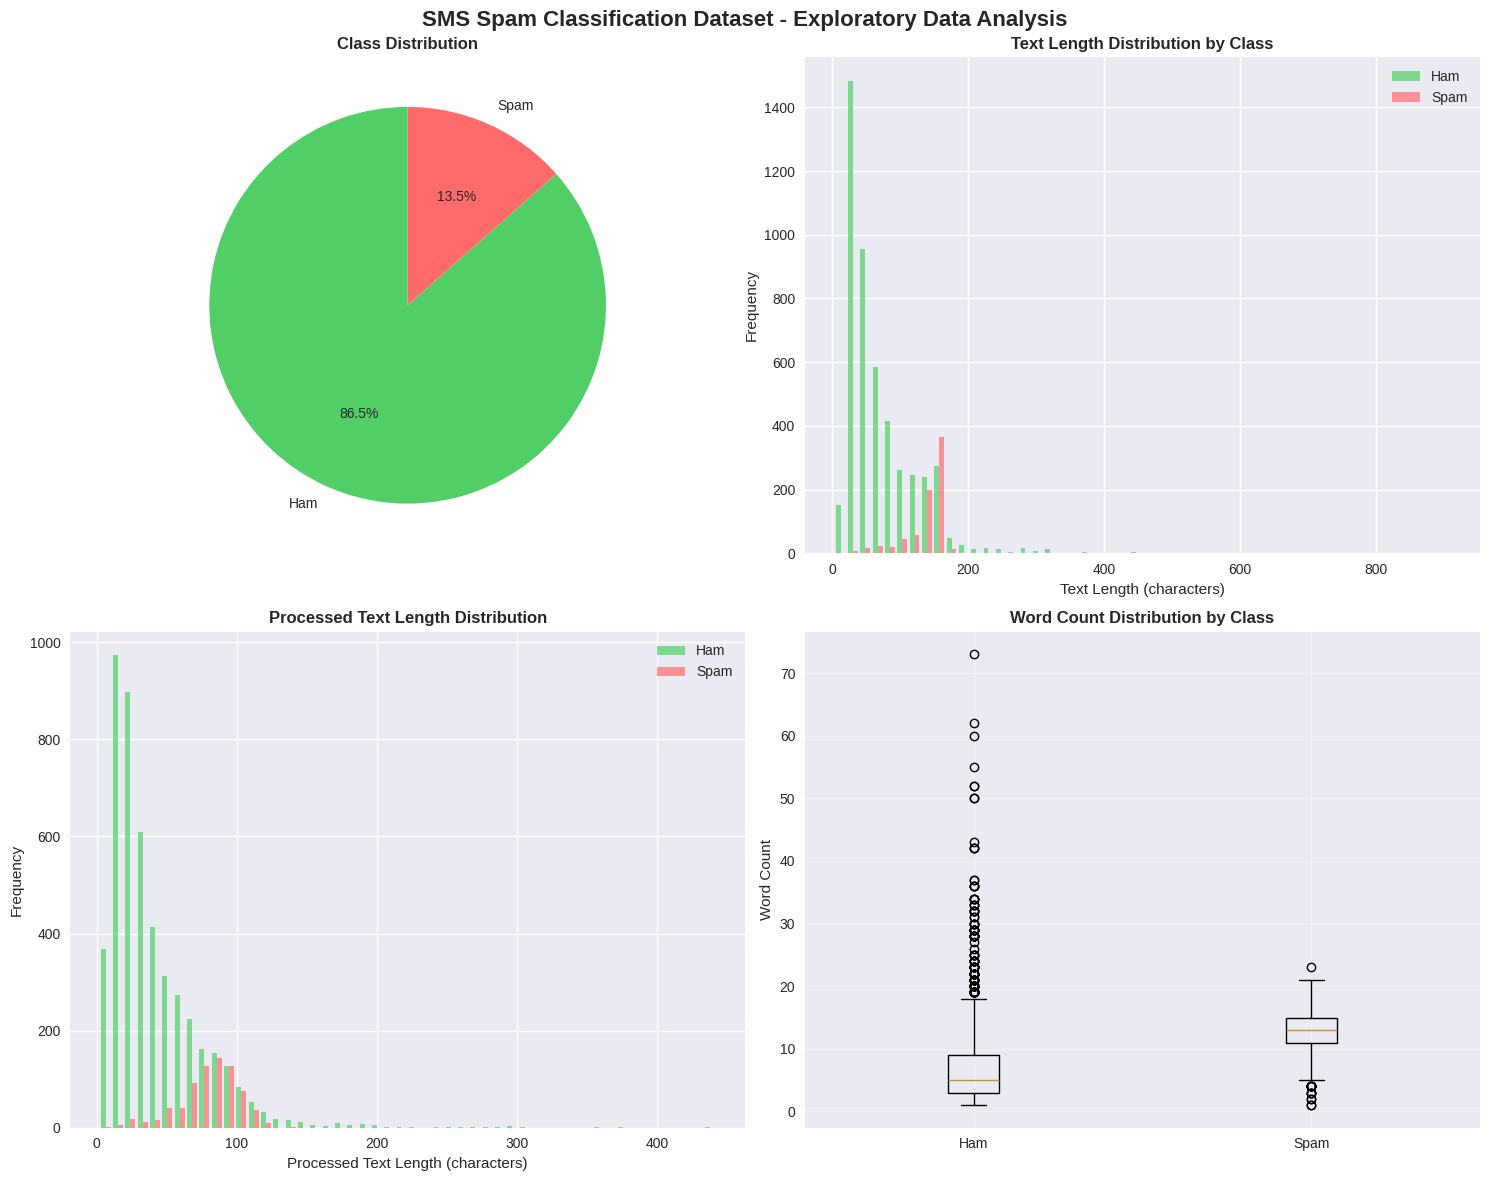

 Statistical Summary:
   - Total samples: 5,532
   - Spam samples: 746 (13.5%)
   - Ham samples: 4,786 (86.5%)

 Text Length Statistics:
   - Original text length: 81.0 ± 59.8 chars
   - Processed text length: 46.4 ± 35.7 chars
   - Average word count: 7.9 ± 5.8 words


In [35]:
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('SMS Spam Classification Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Class Distribution (Spam vs Ham)
class_counts = df['label'].value_counts()
axes[0,0].pie(class_counts.values, labels=['Ham', 'Spam'], autopct='%1.1f%%',
              colors=['#51cf66', '#ff6b6b'], startangle=90)
axes[0,0].set_title('Class Distribution', fontweight='bold')

# 2. Text Length Distribution (Original)
df['text_length'] = df['text'].str.len()
axes[0,1].hist([df[df['label']==0]['text_length'], df[df['label']==1]['text_length']],
               bins=50, alpha=0.7, label=['Ham', 'Spam'], color=['#51cf66', '#ff6b6b'])
axes[0,1].set_xlabel('Text Length (characters)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Text Length Distribution by Class', fontweight='bold')
axes[0,1].legend()

# 3. Processed Text Length Distribution
df['proc_length'] = df['proc'].str.len()
axes[1,0].hist([df[df['label']==0]['proc_length'], df[df['label']==1]['proc_length']],
               bins=50, alpha=0.7, label=['Ham', 'Spam'], color=['#51cf66', '#ff6b6b'])
axes[1,0].set_xlabel('Processed Text Length (characters)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Processed Text Length Distribution', fontweight='bold')
axes[1,0].legend()

# 4. Word Count Distribution
df['word_count'] = df['proc'].str.split().str.len()
axes[1,1].boxplot([df[df['label']==0]['word_count'], df[df['label']==1]['word_count']],
                  labels=['Ham', 'Spam'])
axes[1,1].set_ylabel('Word Count')
axes[1,1].set_title('Word Count Distribution by Class', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print(" Statistical Summary:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Spam samples: {(df['label'] == 1).sum():,} ({(df['label'] == 1).mean():.1%})")
print(f"   - Ham samples: {(df['label'] == 0).sum():,} ({(df['label'] == 0).mean():.1%})")
print(f"\n Text Length Statistics:")
print(f"   - Original text length: {df['text_length'].mean():.1f} ± {df['text_length'].std():.1f} chars")
print(f"   - Processed text length: {df['proc_length'].mean():.1f} ± {df['proc_length'].std():.1f} chars")
print(f"   - Average word count: {df['word_count'].mean():.1f} ± {df['word_count'].std():.1f} words")

🔍 Analyzing word frequencies by class...


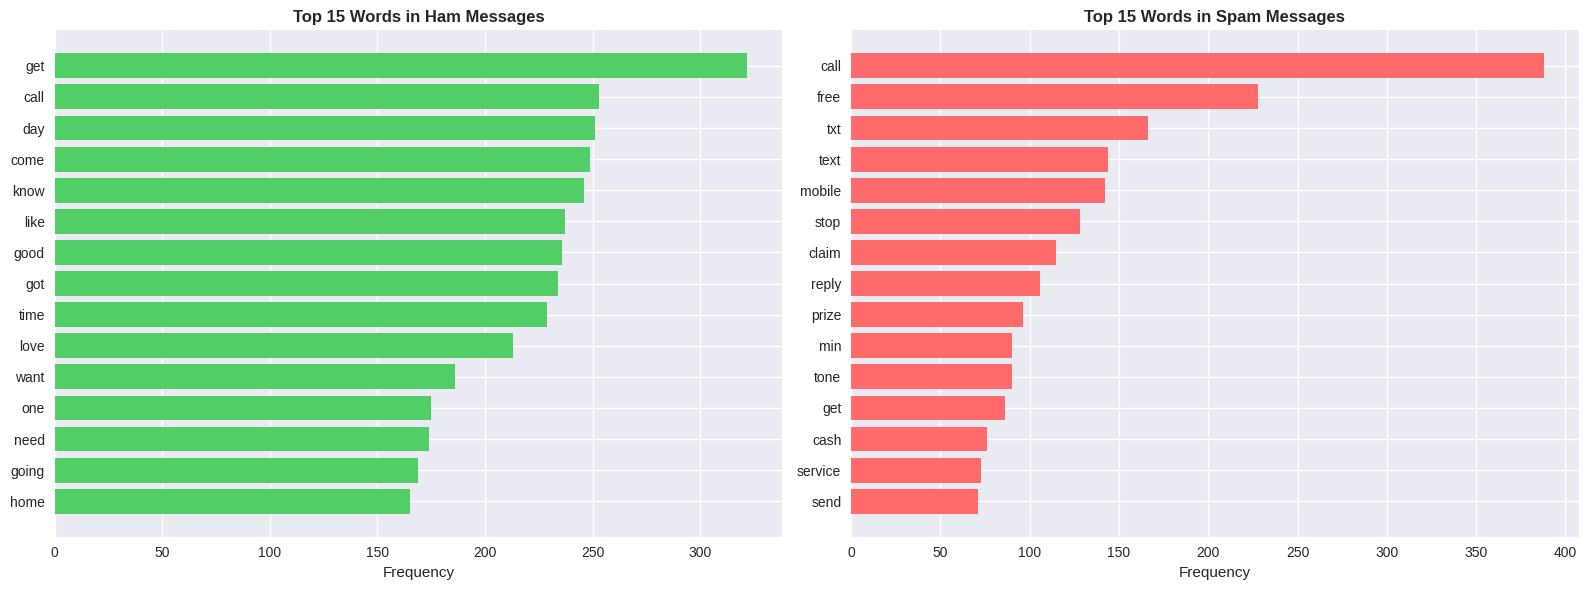


 Sample Messages:
✅ HAM (Legitimate) MESSAGE:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat......

❌ SPAM MESSAGE:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's...


In [36]:
# Word frequency analysis and visualization
from collections import Counter
import matplotlib.pyplot as plt

def analyze_word_frequencies(df):
    """Analyze and visualize word frequencies by class"""
    # Get word frequencies for each class
    spam_texts = ' '.join(df[df['label'] == 1]['proc']).split()
    ham_texts = ' '.join(df[df['label'] == 0]['proc']).split()

    spam_freq = Counter(spam_texts)
    ham_freq = Counter(ham_texts)

    # Get top words
    top_spam = spam_freq.most_common(15)
    top_ham = ham_freq.most_common(15)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Ham (legitimate) words
    words_ham, counts_ham = zip(*top_ham)
    ax1.barh(range(len(words_ham)), counts_ham, color='#51cf66')
    ax1.set_yticks(range(len(words_ham)))
    ax1.set_yticklabels(words_ham)
    ax1.set_title('Top 15 Words in Ham Messages', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Frequency')
    ax1.invert_yaxis()

    # Spam words
    words_spam, counts_spam = zip(*top_spam)
    ax2.barh(range(len(words_spam)), counts_spam, color='#ff6b6b')
    ax2.set_yticks(range(len(words_spam)))
    ax2.set_yticklabels(words_spam)
    ax2.set_title('Top 15 Words in Spam Messages', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Frequency')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

    return spam_freq, ham_freq

# Analyze word frequencies
print("🔍 Analyzing word frequencies by class...")
spam_freq, ham_freq = analyze_word_frequencies(df)

# Show some examples of messages
print(f"\n Sample Messages:")
print("=" * 50)
print("✅ HAM (Legitimate) MESSAGE:")
print(df[df['label'] == 0]['text'].iloc[0][:300] + "...")
print("\n❌ SPAM MESSAGE:")
print(df[df['label'] == 1]['text'].iloc[0][:300] + "...")

## 5. Data Splitting and TF-IDF Feature Engineering

In [37]:
def stratified_splits(df, test_size=0.2, val_size=0.1, seed=42):
    """Create stratified train/validation/test splits"""
    y = df["label"].values
    X = df["proc"].values

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )

    # Second split: separate validation from training
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=seed
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Create stratified splits
print(" Creating stratified train/validation/test splits...")
(X_train, y_train), (X_val, y_val), (X_test, y_test) = stratified_splits(
    df, test_size=0.2, val_size=0.1, seed=42
)

print(f" Split Statistics:")
print(f"   - Training set: {len(X_train):,} samples ({len(X_train)/len(df):.1%})")
print(f"     • Positive: {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")
print(f"     • Negative: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"   - Validation set: {len(X_val):,} samples ({len(X_val)/len(df):.1%})")
print(f"     • Positive: {(y_val == 1).sum():,} ({(y_val == 1).mean():.1%})")
print(f"     • Negative: {(y_val == 0).sum():,} ({(y_val == 0).mean():.1%})")
print(f"   - Test set: {len(X_test):,} samples ({len(X_test)/len(df):.1%})")
print(f"     • Positive: {(y_test == 1).sum():,} ({(y_test == 1).mean():.1%})")
print(f"     • Negative: {(y_test == 0).sum():,} ({(y_test == 0).mean():.1%})")

 Creating stratified train/validation/test splits...
 Split Statistics:
   - Training set: 3,871 samples (70.0%)
     • Positive: 522 (13.5%)
     • Negative: 3,349 (86.5%)
   - Validation set: 554 samples (10.0%)
     • Positive: 75 (13.5%)
     • Negative: 479 (86.5%)
   - Test set: 1,107 samples (20.0%)
     • Positive: 149 (13.5%)
     • Negative: 958 (86.5%)


In [38]:
# TF-IDF Feature Engineering
def build_tfidf_features(X_train, X_val, X_test, max_features=30000, ngram_range=(1,2)):
    """
    Create TF-IDF features for machine learning models

    Parameters:
    - max_features: Maximum number of features to extract
    - ngram_range: Range of n-grams to consider
    """
    print(f" Building TF-IDF features...")
    print(f"   - Max features: {max_features:,}")
    print(f"   - N-gram range: {ngram_range}")

    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=2,        # Ignore terms that appear in less than 2 documents
        max_df=0.98,     # Ignore terms that appear in more than 98% of documents
        sublinear_tf=True,  # Apply sublinear tf scaling
        norm='l2'        # L2 normalization
    )

    # Fit on training data and transform all sets
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)

    print(f" TF-IDF features created:")
    print(f"   - Vocabulary size: {len(vectorizer.vocabulary_):,}")
    print(f"   - Training features shape: {X_train_tfidf.shape}")
    print(f"   - Validation features shape: {X_val_tfidf.shape}")
    print(f"   - Test features shape: {X_test_tfidf.shape}")
    print(f"   - Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.1%}")

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer

# Build TF-IDF features
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = build_tfidf_features(
    X_train, X_val, X_test, max_features=30000, ngram_range=(1,2)
)

 Building TF-IDF features...
   - Max features: 30,000
   - N-gram range: (1, 2)
 TF-IDF features created:
   - Vocabulary size: 5,720
   - Training features shape: (3871, 5720)
   - Validation features shape: (554, 5720)
   - Test features shape: (1107, 5720)
   - Sparsity: 99.8%


## 6. Logistic Regression with TF-IDF - Baseline Model

In [39]:
# Baseline Logistic Regression Model
def train_baseline_model(X_train, y_train, X_val, y_val):
    """Train a baseline logistic regression model"""
    print(" Training baseline Logistic Regression model...")

    # Create baseline model with default parameters
    baseline_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        n_jobs=-1  # Use all available cores
    )

    # Train the model
    baseline_model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = baseline_model.predict(X_train)
    y_val_pred = baseline_model.predict(X_val)

    # Calculate probabilities for AUC and loss
    y_train_proba = baseline_model.predict_proba(X_train)
    y_val_proba = baseline_model.predict_proba(X_val)

    # Calculate metrics including loss
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba[:, 1]),
        'loss': log_loss(y_train, y_train_proba)
    }

    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'auc': roc_auc_score(y_val, y_val_proba[:, 1]),
        'loss': log_loss(y_val, y_val_proba)
    }

    print(" Baseline model training completed!")
    print(f" Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"   - {metric.capitalize()}: {value:.4f}")

    print(f"📊 Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"   - {metric.capitalize()}: {value:.4f}")

    return baseline_model, train_metrics, val_metrics

# Train baseline model
baseline_model, baseline_train_metrics, baseline_val_metrics = train_baseline_model(

    X_train_tfidf, y_train, X_val_tfidf, y_val)

 Training baseline Logistic Regression model...
 Baseline model training completed!
 Training Metrics:
   - Accuracy: 0.9662
   - F1: 0.8584
   - Precision: 0.9851
   - Recall: 0.7605
   - Auc: 0.9978
   - Loss: 0.1299
📊 Validation Metrics:
   - Accuracy: 0.9657
   - F1: 0.8550
   - Precision: 1.0000
   - Recall: 0.7467
   - Auc: 0.9845
   - Loss: 0.1413


## 7. Hyperparameter Tuning - Experiment 1

In [40]:
# Experiment 1: Regularization Parameter Tuning
def hyperparameter_experiment_1(X_train, y_train, X_val, y_val):
    """
    Experiment 1: Test different regularization strengths (C parameter)
    and solvers for Logistic Regression
    """
    print(" Experiment 1: Regularization Parameter Tuning")
    print("=" * 50)

    # Define hyperparameters to test
    C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    solvers = ['liblinear', 'lbfgs', 'saga']

    results = []

    for solver in solvers:
        print(f"\n Testing solver: {solver}")
        for C in C_values:
            # Train model
            model = LogisticRegression(
                C=C,
                solver=solver,
                random_state=42,
                max_iter=1000,
                n_jobs=-1
            )

            # Fit and predict
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            y_val_proba = model.predict_proba(X_val)

            # Calculate metrics
            metrics = {
                'solver': solver,
                'C': C,
                'accuracy': accuracy_score(y_val, y_val_pred),
                'f1': f1_score(y_val, y_val_pred),
                'precision': precision_score(y_val, y_val_pred),
                'recall': recall_score(y_val, y_val_pred),
                'auc': roc_auc_score(y_val, y_val_proba[:, 1]),
                'loss': log_loss(y_val, y_val_proba)
            }

            results.append(metrics)
            print(f"   C={C:6.3f} → Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, AUC: {metrics['auc']:.4f}, Loss: {metrics['loss']:.4f}")

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Find best parameters
    best_idx = results_df['f1'].idxmax()
    best_params = results_df.loc[best_idx]

    print(f"\n Best Parameters (Experiment 1):")
    print(f"   - Solver: {best_params['solver']}")
    print(f"   - C: {best_params['C']}")
    print(f"   - F1 Score: {best_params['f1']:.4f}")
    print(f"   - Accuracy: {best_params['accuracy']:.4f}")
    print(f"   - AUC: {best_params['auc']:.4f}")
    print(f"   - Loss: {best_params['loss']:.4f}")

    return results_df, best_params

# Run Experiment 1
exp1_results, exp1_best = hyperparameter_experiment_1(
    X_train_tfidf, y_train, X_val_tfidf, y_val
)

 Experiment 1: Regularization Parameter Tuning

 Testing solver: liblinear
   C= 0.001 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9628, Loss: 0.4899
   C= 0.010 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9753, Loss: 0.3902
   C= 0.100 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9795, Loss: 0.3027
   C= 1.000 → Accuracy: 0.9675, F1: 0.8636, AUC: 0.9844, Loss: 0.1416
   C=10.000 → Accuracy: 0.9874, F1: 0.9510, AUC: 0.9838, Loss: 0.0725
   C=100.000 → Accuracy: 0.9856, F1: 0.9444, AUC: 0.9825, Loss: 0.0624

 Testing solver: lbfgs
   C= 0.001 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9781, Loss: 0.3952
   C= 0.010 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9784, Loss: 0.3842
   C= 0.100 → Accuracy: 0.8646, F1: 0.0000, AUC: 0.9800, Loss: 0.3020
   C= 1.000 → Accuracy: 0.9657, F1: 0.8550, AUC: 0.9845, Loss: 0.1413
   C=10.000 → Accuracy: 0.9856, F1: 0.9437, AUC: 0.9839, Loss: 0.0722
   C=100.000 → Accuracy: 0.9801, F1: 0.9241, AUC: 0.9828, Loss: 0.0647

 Testing solver: saga
   C= 0.001 → Accuracy: 0.8646, F1: 

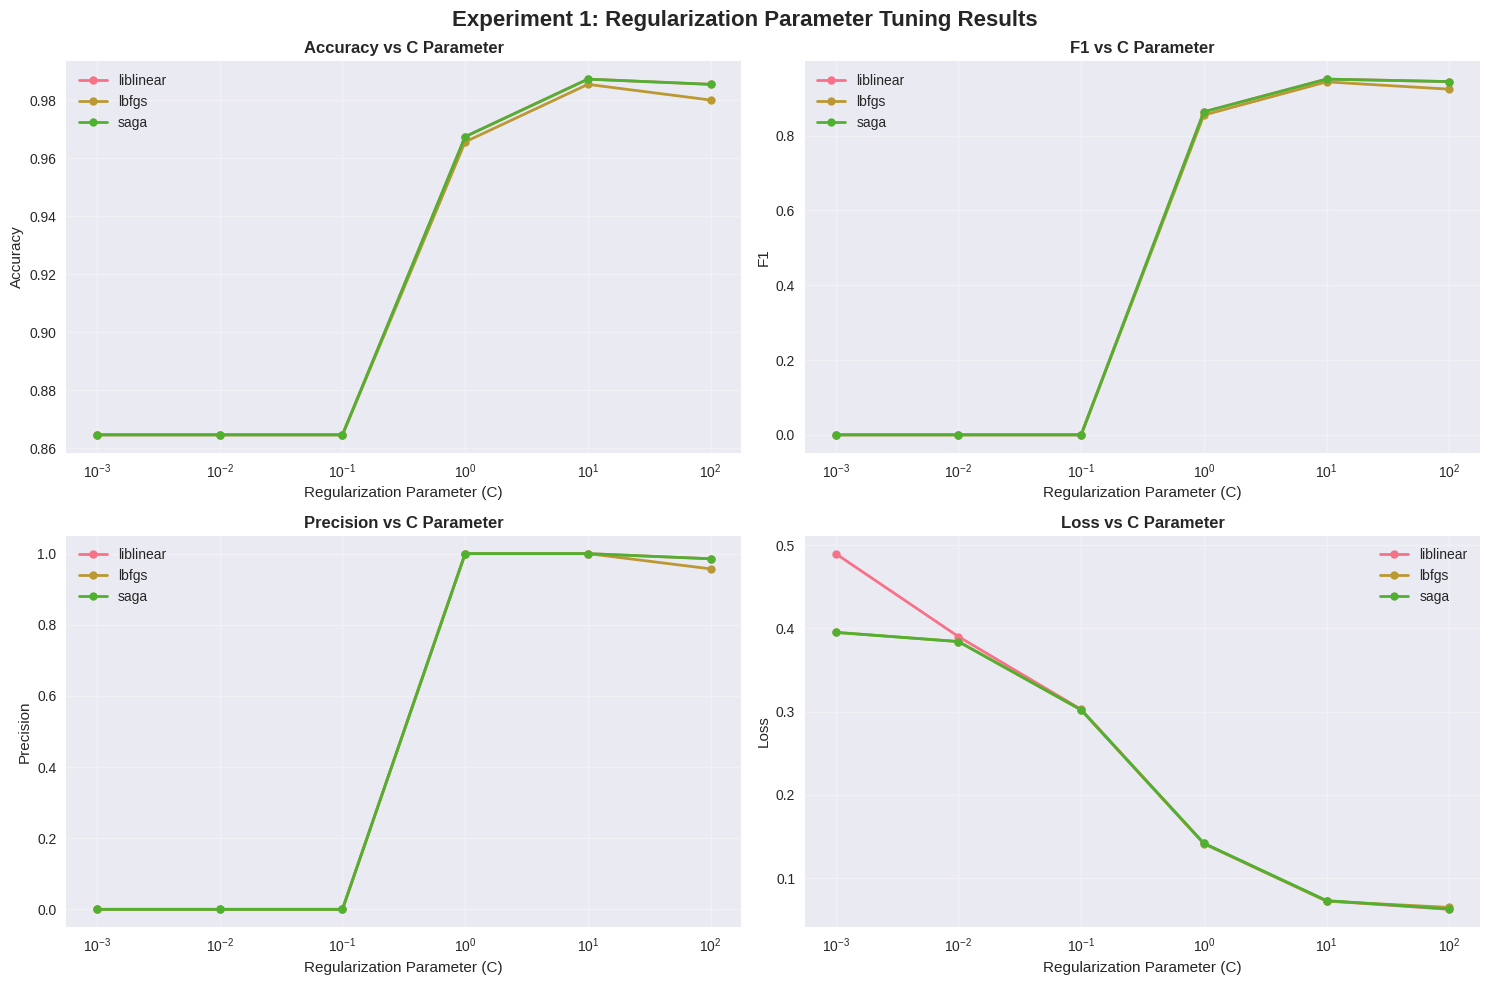


 Experiment 1 Results Table:
        accuracy                       auc                        f1  \
solver     lbfgs liblinear    saga   lbfgs liblinear    saga   lbfgs   
C                                                                      
0.001     0.8646    0.8646  0.8646  0.9781    0.9628  0.9781  0.0000   
0.010     0.8646    0.8646  0.8646  0.9784    0.9753  0.9784  0.0000   
0.100     0.8646    0.8646  0.8646  0.9800    0.9795  0.9799  0.0000   
1.000     0.9657    0.9675  0.9675  0.9845    0.9844  0.9843  0.8550   
10.000    0.9856    0.9874  0.9874  0.9839    0.9838  0.9836  0.9437   
100.000   0.9801    0.9856  0.9856  0.9828    0.9825  0.9819  0.9241   

                             loss                    
solver  liblinear    saga   lbfgs liblinear    saga  
C                                                    
0.001      0.0000  0.0000  0.3952    0.4899  0.3952  
0.010      0.0000  0.0000  0.3842    0.3902  0.3842  
0.100      0.0000  0.0000  0.3020    0.3027  0.3021

In [41]:
# Visualize Experiment 1 Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 1: Regularization Parameter Tuning Results', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'f1', 'precision', 'loss']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[i//2, i%2]

    # Plot for each solver
    for solver in exp1_results['solver'].unique():
        solver_data = exp1_results[exp1_results['solver'] == solver]
        ax.plot(solver_data['C'], solver_data[metric],
               marker='o', label=solver, linewidth=2, markersize=6)

    ax.set_xscale('log')
    ax.set_xlabel('Regularization Parameter (C)')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} vs C Parameter', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Create results table for Experiment 1
print("\n Experiment 1 Results Table:")
print("=" * 80)
pivot_table = exp1_results.pivot_table(
    values=['accuracy', 'f1', 'auc', 'loss'],
    index='C',
    columns='solver',
    aggfunc='mean'
)
print(pivot_table.round(4))

## 8. Hyperparameter Tuning - Experiment 2

In [42]:
# Experiment 2: Feature Engineering Parameter Tuning
def hyperparameter_experiment_2():
    """
    Experiment 2: Test different TF-IDF parameters and feature engineering approaches
    """
    print(" Experiment 2: Feature Engineering Parameter Tuning")
    print("=" * 50)

    # Define TF-IDF parameters to test
    experiments = [
        {'max_features': 10000, 'ngram_range': (1,1), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 20000, 'ngram_range': (1,1), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 30000, 'ngram_range': (1,1), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 10000, 'ngram_range': (1,2), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 20000, 'ngram_range': (1,2), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 30000, 'ngram_range': (1,2), 'min_df': 2, 'max_df': 0.98},
        {'max_features': 20000, 'ngram_range': (1,3), 'min_df': 3, 'max_df': 0.95},
        {'max_features': 25000, 'ngram_range': (1,2), 'min_df': 3, 'max_df': 0.95},
    ]

    results = []

    for i, params in enumerate(experiments):
        print(f"\n Testing configuration {i+1}/8:")
        print(f"   Max features: {params['max_features']:,}")
        print(f"   N-gram range: {params['ngram_range']}")
        print(f"   Min DF: {params['min_df']}, Max DF: {params['max_df']}")

        # Create TF-IDF vectorizer with current parameters
        vectorizer = TfidfVectorizer(
            max_features=params['max_features'],
            ngram_range=params['ngram_range'],
            min_df=params['min_df'],
            max_df=params['max_df'],
            sublinear_tf=True,
            norm='l2'
        )

        # Transform data
        X_tr_exp = vectorizer.fit_transform(X_train)
        X_val_exp = vectorizer.transform(X_val)

        # Train model with best parameters from Experiment 1
        model = LogisticRegression(
            C=exp1_best['C'],
            solver=exp1_best['solver'],
            random_state=42,
            max_iter=1000,
            n_jobs=-1
        )

        model.fit(X_tr_exp, y_train)
        y_val_pred = model.predict(X_val_exp)
        y_val_proba = model.predict_proba(X_val_exp)

        # Calculate metrics
        result = {
            'config': i+1,
            'max_features': params['max_features'],
            'ngram_range': str(params['ngram_range']),
            'min_df': params['min_df'],
            'max_df': params['max_df'],
            'vocab_size': len(vectorizer.vocabulary_),
            'accuracy': accuracy_score(y_val, y_val_pred),
            'f1': f1_score(y_val, y_val_pred),
            'precision': precision_score(y_val, y_val_pred),
            'recall': recall_score(y_val, y_val_pred),
            'auc': roc_auc_score(y_val, y_val_proba[:, 1]),
            'loss': log_loss(y_val, y_val_proba)
        }

        results.append(result)
        print(f"   → Accuracy: {result['accuracy']:.4f}, F1: {result['f1']:.4f}, AUC: {result['auc']:.4f}, Loss: {result['loss']:.4f}")
        print(f"   → Vocabulary size: {result['vocab_size']:,}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find best configuration
    best_idx = results_df['f1'].idxmax()
    best_config = results_df.loc[best_idx]

    print(f"\n Best Configuration (Experiment 2):")
    print(f"   - Max features: {best_config['max_features']:,}")
    print(f"   - N-gram range: {best_config['ngram_range']}")
    print(f"   - Min DF: {best_config['min_df']}, Max DF: {best_config['max_df']}")
    print(f"   - Vocabulary size: {best_config['vocab_size']:,}")
    print(f"   - F1 Score: {best_config['f1']:.4f}")
    print(f"   - Accuracy: {best_config['accuracy']:.4f}")
    print(f"   - AUC: {best_config['auc']:.4f}")
    print(f"   - Loss: {best_config['loss']:.4f}")

    return results_df, best_config

# Run Experiment 2
exp2_results, exp2_best = hyperparameter_experiment_2()

 Experiment 2: Feature Engineering Parameter Tuning

 Testing configuration 1/8:
   Max features: 10,000
   N-gram range: (1, 1)
   Min DF: 2, Max DF: 0.98
   → Accuracy: 0.9838, F1: 0.9362, AUC: 0.9861, Loss: 0.0690
   → Vocabulary size: 2,641

 Testing configuration 2/8:
   Max features: 20,000
   N-gram range: (1, 1)
   Min DF: 2, Max DF: 0.98
   → Accuracy: 0.9838, F1: 0.9362, AUC: 0.9861, Loss: 0.0690
   → Vocabulary size: 2,641

 Testing configuration 3/8:
   Max features: 30,000
   N-gram range: (1, 1)
   Min DF: 2, Max DF: 0.98
   → Accuracy: 0.9838, F1: 0.9362, AUC: 0.9861, Loss: 0.0690
   → Vocabulary size: 2,641

 Testing configuration 4/8:
   Max features: 10,000
   N-gram range: (1, 2)
   Min DF: 2, Max DF: 0.98
   → Accuracy: 0.9874, F1: 0.9510, AUC: 0.9838, Loss: 0.0725
   → Vocabulary size: 5,720

 Testing configuration 5/8:
   Max features: 20,000
   N-gram range: (1, 2)
   Min DF: 2, Max DF: 0.98
   → Accuracy: 0.9874, F1: 0.9510, AUC: 0.9838, Loss: 0.0725
   → Vocabu

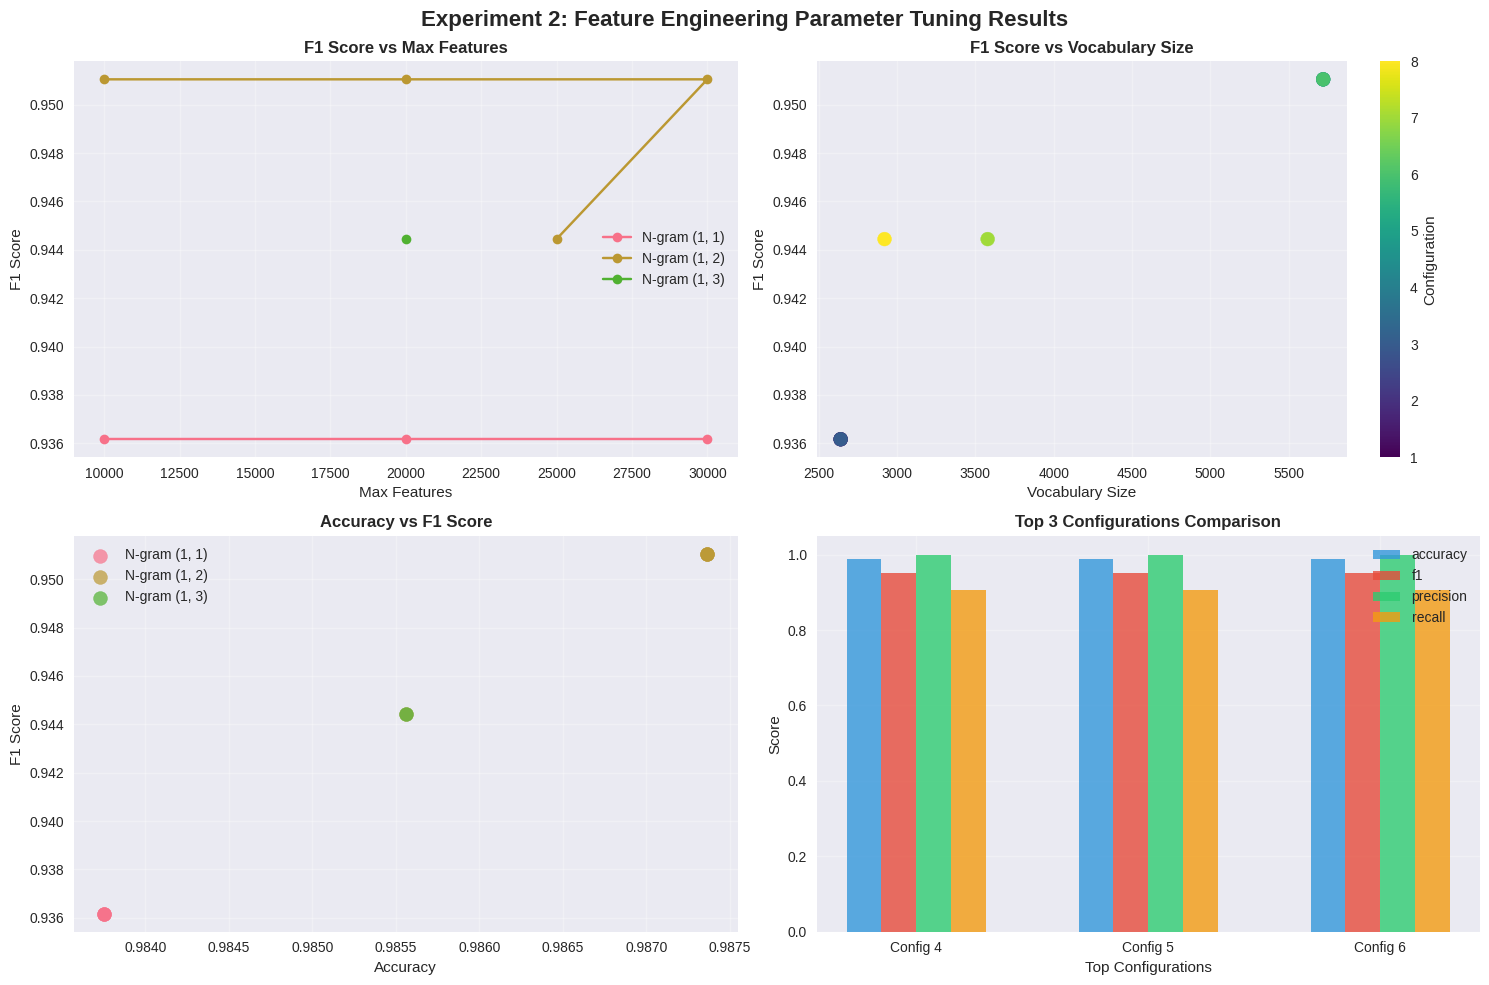


 Experiment 2 Results Table:
 config  max_features ngram_range  vocab_size  accuracy     f1  precision  recall    auc   loss
      1         10000      (1, 1)        2641    0.9838 0.9362     1.0000  0.8800 0.9861 0.0690
      2         20000      (1, 1)        2641    0.9838 0.9362     1.0000  0.8800 0.9861 0.0690
      3         30000      (1, 1)        2641    0.9838 0.9362     1.0000  0.8800 0.9861 0.0690
      4         10000      (1, 2)        5720    0.9874 0.9510     1.0000  0.9067 0.9838 0.0725
      5         20000      (1, 2)        5720    0.9874 0.9510     1.0000  0.9067 0.9838 0.0725
      6         30000      (1, 2)        5720    0.9874 0.9510     1.0000  0.9067 0.9838 0.0725
      7         20000      (1, 3)        3579    0.9856 0.9444     0.9855  0.9067 0.9836 0.0723
      8         25000      (1, 2)        2921    0.9856 0.9444     0.9855  0.9067 0.9841 0.0713


In [43]:
# Visualize Experiment 2 Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 2: Feature Engineering Parameter Tuning Results', fontsize=16, fontweight='bold')

# 1. Performance by Max Features
ax1 = axes[0,0]
for ngram in exp2_results['ngram_range'].unique():
    data = exp2_results[exp2_results['ngram_range'] == ngram]
    ax1.plot(data['max_features'], data['f1'], marker='o', label=f'N-gram {ngram}')
ax1.set_xlabel('Max Features')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score vs Max Features', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Performance by Vocabulary Size
ax2 = axes[0,1]
scatter = ax2.scatter(exp2_results['vocab_size'], exp2_results['f1'],
                     c=exp2_results['config'], cmap='viridis', s=100)
ax2.set_xlabel('Vocabulary Size')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Vocabulary Size', fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Configuration')

# 3. Accuracy vs F1 Score
ax3 = axes[1,0]
for ngram in exp2_results['ngram_range'].unique():
    data = exp2_results[exp2_results['ngram_range'] == ngram]
    ax3.scatter(data['accuracy'], data['f1'], label=f'N-gram {ngram}', s=100, alpha=0.7)
ax3.set_xlabel('Accuracy')
ax3.set_ylabel('F1 Score')
ax3.set_title('Accuracy vs F1 Score', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Bar chart of all metrics for best configurations
ax4 = axes[1,1]
top_3 = exp2_results.nlargest(3, 'f1')[['config', 'accuracy', 'f1', 'precision', 'recall']]
x = range(len(top_3))
width = 0.15
metrics = ['accuracy', 'f1', 'precision', 'recall']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics):
    ax4.bar([j + i*width for j in x], top_3[metric], width, label=metric, color=colors[i], alpha=0.8)

ax4.set_xlabel('Top Configurations')
ax4.set_ylabel('Score')
ax4.set_title('Top 3 Configurations Comparison', fontweight='bold')
ax4.set_xticks([j + width*1.5 for j in x])
ax4.set_xticklabels([f'Config {int(c)}' for c in top_3['config']])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display Experiment 2 results table
print("\n Experiment 2 Results Table:")
print("=" * 100)
display_cols = ['config', 'max_features', 'ngram_range', 'vocab_size', 'accuracy', 'f1', 'precision', 'recall', 'auc', 'loss']
print(exp2_results[display_cols].round(4).to_string(index=False))

## 9. Final Model Training and Evaluation

In [44]:
# Train Final Optimized Model
def train_final_model():
    """Train the final optimized model using best parameters from experiments"""

    print(" Training Final Optimized Logistic Regression Model")
    print("=" * 50)

    # Use best parameters from experiments
    print(" Using optimized parameters:")
    print(f"   - Solver: {exp1_best['solver']}")
    print(f"   - C: {exp1_best['C']}")
    print(f"   - Max features: {int(exp2_best['max_features']):,}")
    print(f"   - N-gram range: {eval(exp2_best['ngram_range'])}")
    print(f"   - Min DF: {exp2_best['min_df']}")
    print(f"   - Max DF: {exp2_best['max_df']}")

    # Create optimized TF-IDF vectorizer
    final_vectorizer = TfidfVectorizer(
        max_features=int(exp2_best['max_features']),
        ngram_range=eval(exp2_best['ngram_range']),
        min_df=exp2_best['min_df'],
        max_df=exp2_best['max_df'],
        sublinear_tf=True,
        norm='l2'
    )

    # Transform data with optimized parameters
    X_train_final = final_vectorizer.fit_transform(X_train)
    X_val_final = final_vectorizer.transform(X_val)
    X_test_final = final_vectorizer.transform(X_test)

    print(f"\n Final feature dimensions: {X_train_final.shape}")
    print(f"   - Vocabulary size: {len(final_vectorizer.vocabulary_):,}")
    print(f"   - Sparsity: {(1 - X_train_final.nnz / (X_train_final.shape[0] * X_train_final.shape[1])):.1%}")

    # Create optimized model
    final_model = LogisticRegression(
        C=exp1_best['C'],
        solver=exp1_best['solver'],
        random_state=42,
        max_iter=1000,
        n_jobs=-1
    )

    # Train model
    final_model.fit(X_train_final, y_train)

    # Make predictions on all sets
    y_train_pred = final_model.predict(X_train_final)
    y_val_pred = final_model.predict(X_val_final)
    y_test_pred = final_model.predict(X_test_final)

    # Get probabilities for ROC curves and loss calculation
    y_train_proba_full = final_model.predict_proba(X_train_final)
    y_val_proba_full = final_model.predict_proba(X_val_final)
    y_test_proba_full = final_model.predict_proba(X_test_final)

    y_train_proba = y_train_proba_full[:, 1]
    y_val_proba = y_val_proba_full[:, 1]
    y_test_proba = y_test_proba_full[:, 1]

    # Calculate comprehensive metrics
    sets = ['Train', 'Validation', 'Test']
    y_true_sets = [y_train, y_val, y_test]
    y_pred_sets = [y_train_pred, y_val_pred, y_test_pred]
    y_proba_sets = [y_train_proba, y_val_proba, y_test_proba]
    y_proba_full_sets = [y_train_proba_full, y_val_proba_full, y_test_proba_full]

    final_results = {}

    print(f"\n Final Model Performance:")
    for set_name, y_true, y_pred, y_proba, y_proba_full in zip(sets, y_true_sets, y_pred_sets, y_proba_sets, y_proba_full_sets):
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_proba),
            'loss': log_loss(y_true, y_proba_full)
        }
        final_results[set_name] = metrics

        print(f"\n{set_name} Set:")
        for metric, value in metrics.items():
            print(f"   - {metric.capitalize()}: {value:.4f}")

    return final_model, final_vectorizer, final_results, (X_train_final, X_val_final, X_test_final)

# Train final model
final_model, final_vectorizer, final_results, final_features = train_final_model()

 Training Final Optimized Logistic Regression Model
 Using optimized parameters:
   - Solver: liblinear
   - C: 10.0
   - Max features: 10,000
   - N-gram range: (1, 2)
   - Min DF: 2
   - Max DF: 0.98

 Final feature dimensions: (3871, 5720)
   - Vocabulary size: 5,720
   - Sparsity: 99.8%

 Final Model Performance:

Train Set:
   - Accuracy: 0.9977
   - F1: 0.9914
   - Precision: 0.9942
   - Recall: 0.9885
   - Auc: 1.0000
   - Loss: 0.0335

Validation Set:
   - Accuracy: 0.9874
   - F1: 0.9510
   - Precision: 1.0000
   - Recall: 0.9067
   - Auc: 0.9838
   - Loss: 0.0725

Test Set:
   - Accuracy: 0.9819
   - F1: 0.9286
   - Precision: 0.9924
   - Recall: 0.8725
   - Auc: 0.9893
   - Loss: 0.0732


## 10. Comprehensive Model Evaluation and Visualization

 Creating comprehensive evaluation visualizations...


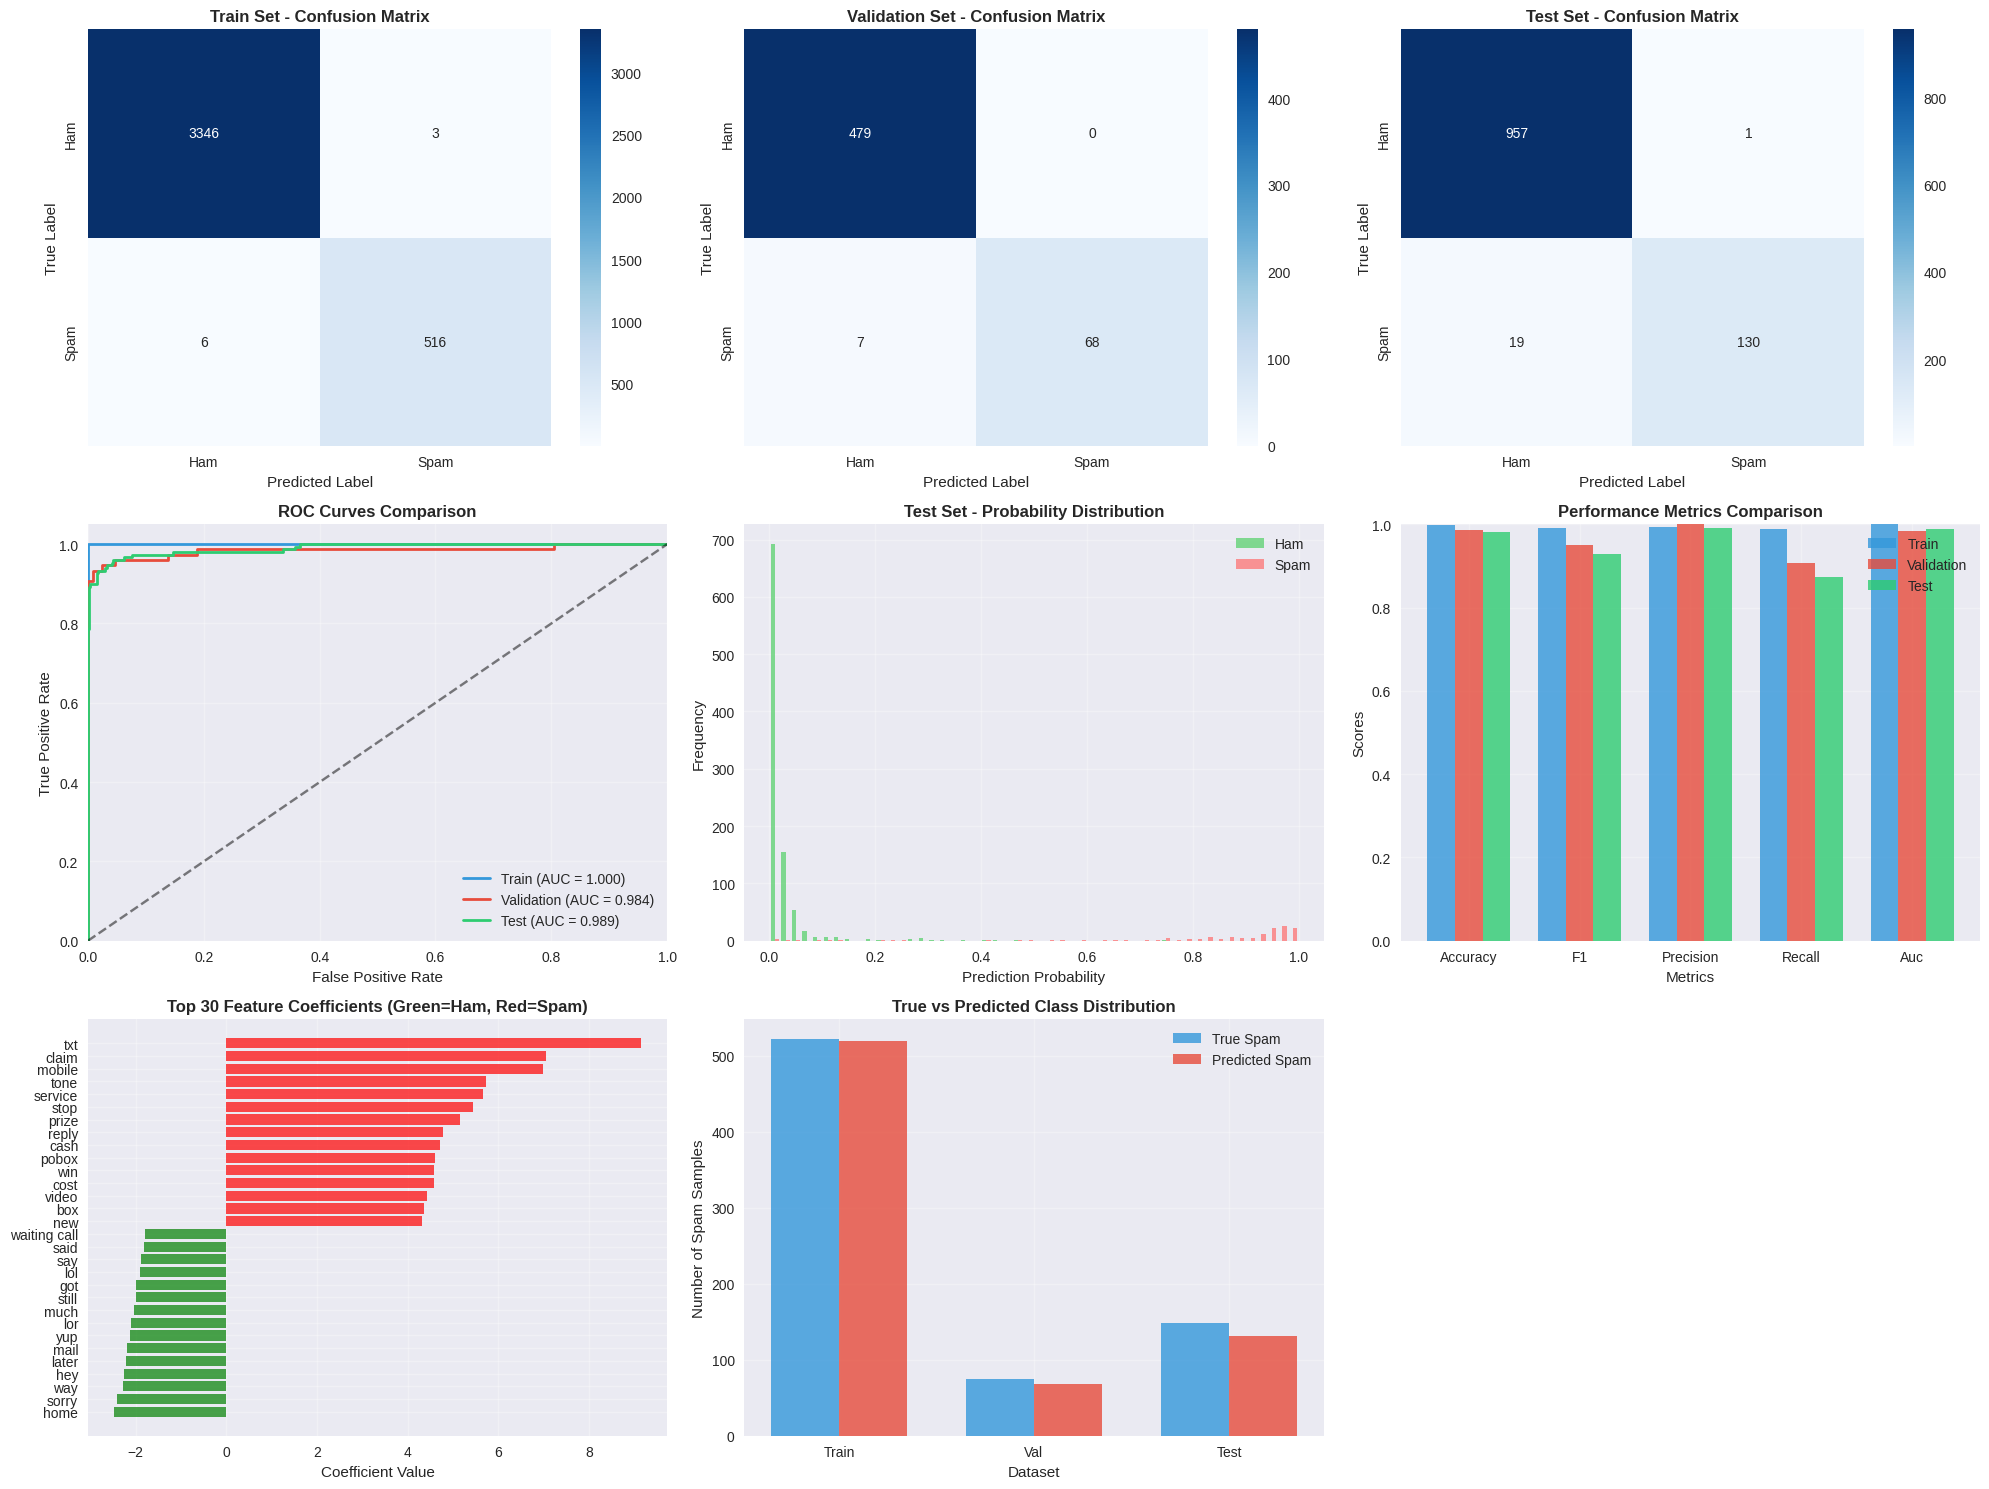

In [45]:
# Comprehensive Evaluation Visualizations
def create_evaluation_plots():
    """Create comprehensive evaluation plots for the final model"""

    # Get predictions and probabilities
    X_train_final, X_val_final, X_test_final = final_features

    y_train_pred = final_model.predict(X_train_final)
    y_val_pred = final_model.predict(X_val_final)
    y_test_pred = final_model.predict(X_test_final)

    y_train_proba = final_model.predict_proba(X_train_final)[:, 1]
    y_val_proba = final_model.predict_proba(X_val_final)[:, 1]
    y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrices
    for i, (set_name, y_true, y_pred) in enumerate(zip(['Train', 'Validation', 'Test'],
                                                       [y_train, y_val, y_test],
                                                       [y_train_pred, y_val_pred, y_test_pred])):
        ax = plt.subplot(3, 3, i+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Ham', 'Spam'],
                   yticklabels=['Ham', 'Spam'])
        plt.title(f'{set_name} Set - Confusion Matrix', fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    # 2. ROC Curves
    ax = plt.subplot(3, 3, 4)
    sets_data = [
        ('Train', y_train, y_train_proba, '#3498db'),
        ('Validation', y_val, y_val_proba, '#e74c3c'),
        ('Test', y_test, y_test_proba, '#2ecc71')
    ]

    for set_name, y_true, y_proba, color in sets_data:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc_score = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, color=color, linewidth=2,
                label=f'{set_name} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Prediction Probability Distributions
    ax = plt.subplot(3, 3, 5)
    plt.hist([y_test_proba[y_test==0], y_test_proba[y_test==1]],
             bins=50, alpha=0.7, label=['Ham', 'Spam'],
             color=['#51cf66', '#ff6b6b'])
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Test Set - Probability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Performance Metrics Comparison
    ax = plt.subplot(3, 3, 6)
    metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
    train_scores = [final_results['Train'][m] for m in metrics]
    val_scores = [final_results['Validation'][m] for m in metrics]
    test_scores = [final_results['Test'][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, train_scores, width, label='Train', alpha=0.8, color='#3498db')
    plt.bar(x, val_scores, width, label='Validation', alpha=0.8, color='#e74c3c')
    plt.bar(x + width, test_scores, width, label='Test', alpha=0.8, color='#2ecc71')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison', fontweight='bold')
    plt.xticks(x, [m.capitalize() for m in metrics])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    # 5. Feature Importance (Top coefficients)
    ax = plt.subplot(3, 3, 7)
    feature_names = final_vectorizer.get_feature_names_out()
    coefficients = final_model.coef_[0]

    # Get top positive and negative coefficients
    top_spam_idx = np.argsort(coefficients)[-15:]  # Positive coefs = spam indicators
    top_ham_idx = np.argsort(coefficients)[:15]     # Negative coefs = ham indicators

    top_features = np.concatenate([top_ham_idx, top_spam_idx])
    top_coeffs = coefficients[top_features]
    top_names = [feature_names[i] for i in top_features]

    colors = ['green' if coef < 0 else 'red' for coef in top_coeffs]
    plt.barh(range(len(top_coeffs)), top_coeffs, color=colors, alpha=0.7)
    plt.yticks(range(len(top_names)), top_names)
    plt.xlabel('Coefficient Value')
    plt.title('Top 30 Feature Coefficients (Green=Ham, Red=Spam)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 6. Class Distribution in Predictions
    ax = plt.subplot(3, 3, 8)
    sets = ['Train', 'Val', 'Test']
    true_spam = [np.sum(y_train), np.sum(y_val), np.sum(y_test)]
    pred_spam = [np.sum(y_train_pred), np.sum(y_val_pred), np.sum(y_test_pred)]

    x = np.arange(len(sets))
    width = 0.35

    plt.bar(x - width/2, true_spam, width, label='True Spam', alpha=0.8, color='#3498db')
    plt.bar(x + width/2, pred_spam, width, label='Predicted Spam', alpha=0.8, color='#e74c3c')

    plt.xlabel('Dataset')
    plt.ylabel('Number of Spam Samples')
    plt.title('True vs Predicted Class Distribution', fontweight='bold')
    plt.xticks(x, sets)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create evaluation plots
print(" Creating comprehensive evaluation visualizations...")
create_evaluation_plots()

## 11. Model Interpretation and Feature Analysis

In [46]:
# Model Interpretation and Error Analysis
def analyze_model_performance():
    """Analyze model performance and provide interpretations"""

    print(" Model Performance Analysis")
    print("=" * 50)

    # Get final predictions
    X_train_final, X_val_final, X_test_final = final_features
    y_test_pred = final_model.predict(X_test_final)
    y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

    # Classification Report
    print("\n Detailed Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred,
                              target_names=['Ham', 'Spam'],
                              digits=4))

    # Error Analysis
    print("\n Error Analysis:")

    # False Positives (Predicted Spam, Actually Ham)
    fp_mask = (y_test == 0) & (y_test_pred == 1)
    fp_count = np.sum(fp_mask)
    fp_confidence = y_test_proba[fp_mask].mean() if fp_count > 0 else 0

    # False Negatives (Predicted Ham, Actually Spam)
    fn_mask = (y_test == 1) & (y_test_pred == 0)
    fn_count = np.sum(fn_mask)
    fn_confidence = y_test_proba[fn_mask].mean() if fn_count > 0 else 0

    print(f"   - False Positives: {fp_count} ({fp_count/len(y_test):.1%} of test set)")
    print(f"     Average confidence: {fp_confidence:.3f}")
    print(f"   - False Negatives: {fn_count} ({fn_count/len(y_test):.1%} of test set)")
    print(f"     Average confidence: {fn_confidence:.3f}")

    # Show some misclassified examples
    if fp_count > 0:
        print(f"\n Example False Positive (Predicted Spam, Actually Ham):")
        fp_indices = np.where(fp_mask)[0]
        example_idx = fp_indices[0]
        print(f"   Confidence: {y_test_proba[example_idx]:.3f}")
        print(f"   Text: {X_test[example_idx][:200]}...")

    if fn_count > 0:
        print(f"\n Example False Negative (Predicted Ham, Actually Spam):")
        fn_indices = np.where(fn_mask)[0]
        example_idx = fn_indices[0]
        print(f"   Confidence: {y_test_proba[example_idx]:.3f}")
        print(f"   Text: {X_test[example_idx][:200]}...")

    # Model Confidence Analysis
    print(f"\n Prediction Confidence Analysis:")
    high_conf_correct = np.sum((y_test_pred == y_test) & (np.abs(y_test_proba - 0.5) > 0.3))
    low_conf_correct = np.sum((y_test_pred == y_test) & (np.abs(y_test_proba - 0.5) <= 0.3))
    high_conf_wrong = np.sum((y_test_pred != y_test) & (np.abs(y_test_proba - 0.5) > 0.3))
    low_conf_wrong = np.sum((y_test_pred != y_test) & (np.abs(y_test_proba - 0.5) <= 0.3))

    print(f"   - High confidence correct: {high_conf_correct} ({high_conf_correct/len(y_test):.1%})")
    print(f"   - Low confidence correct: {low_conf_correct} ({low_conf_correct/len(y_test):.1%})")
    print(f"   - High confidence wrong: {high_conf_wrong} ({high_conf_wrong/len(y_test):.1%})")
    print(f"   - Low confidence wrong: {low_conf_wrong} ({low_conf_wrong/len(y_test):.1%})")

    # Top predictive features
    print(f"\n Most Predictive Features:")
    feature_names = final_vectorizer.get_feature_names_out()
    coefficients = final_model.coef_[0]

    # Top spam indicators (positive coefficients)
    top_spam_idx = np.argsort(coefficients)[-10:]
    print("   Top 10 Spam Indicators:")
    for i, idx in enumerate(reversed(top_spam_idx)):
        print(f"      {i+1}. '{feature_names[idx]}' (coef: {coefficients[idx]:.3f})")

    # Top ham indicators (negative coefficients)
    top_ham_idx = np.argsort(coefficients)[:10]
    print("   Top 10 Ham Indicators:")
    for i, idx in enumerate(top_ham_idx):
        print(f"      {i+1}. '{feature_names[idx]}' (coef: {coefficients[idx]:.3f})")

# Run analysis
analyze_model_performance()

 Model Performance Analysis

 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Ham     0.9805    0.9990    0.9897       958
        Spam     0.9924    0.8725    0.9286       149

    accuracy                         0.9819      1107
   macro avg     0.9864    0.9357    0.9591      1107
weighted avg     0.9821    0.9819    0.9814      1107


 Error Analysis:
   - False Positives: 1 (0.1% of test set)
     Average confidence: 0.755
   - False Negatives: 19 (1.7% of test set)
     Average confidence: 0.189

 Example False Positive (Predicted Spam, Actually Ham):
   Confidence: 0.755
   Text: typical reply...

 Example False Negative (Predicted Ham, Actually Spam):
   Confidence: 0.205
   Text: freemsg hey darling week word back like fun still xxx std chgs send rcv...

 Prediction Confidence Analysis:
   - High confidence correct: 1051 (94.9%)
   - Low confidence correct: 36 (3.3%)
   - High confidence wrong: 10 (0.9%)
   - Low conf

In [47]:
# Save the final model and results for future use
import os
import pickle
import json

# Create output directory
os.makedirs("models", exist_ok=True)

# Save the trained model
with open("models/final_logistic_regression_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Save the vectorizer
with open("models/final_tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(final_vectorizer, f)

# Save experiment results - Convert numpy types to native Python types for JSON serialization
def convert_to_json_serializable(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_json_serializable(item) for item in obj]
    elif hasattr(obj, 'item'):  # numpy scalar types
        return obj.item()
    elif isinstance(obj, (np.int64, np.int32, np.float64, np.float32)):
        return obj.item()
    else:
        return obj

results_summary = {
    "dataset": "SMS Spam Collection (UCI)",
    "model": "Logistic Regression",
    "embedding": "TF-IDF",
    "author": "Carine Ashimwe",
    "baseline_results": {
        "train": convert_to_json_serializable(baseline_train_metrics),
        "validation": convert_to_json_serializable(baseline_val_metrics)
    },
    "experiment_1_best": convert_to_json_serializable(dict(exp1_best)),
    "experiment_2_best": convert_to_json_serializable(dict(exp2_best)),
    "final_results": convert_to_json_serializable(final_results)
}

with open("models/experiment_results.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print(" Model and Results Saved Successfully!")
print(" Saved files:")
print("   - models/final_logistic_regression_model.pkl")
print("   - models/final_tfidf_vectorizer.pkl")
print("   - models/experiment_results.json")

# Function to make predictions on new text
def predict_spam(text, model=final_model, vectorizer=final_vectorizer):
    """
    Predict spam/ham for new text input

    Args:
        text (str): Input SMS text to classify
        model: Trained logistic regression model
        vectorizer: Fitted TF-IDF vectorizer

    Returns:
        dict: Prediction results with probability and class
    """
    # Preprocess the text (same as training)
    clean = clean_text(text)
    processed = lemmatize_and_filter(clean)

    # Vectorize
    features = vectorizer.transform([processed])

    # Predict
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]

    return {
        "text": text,
        "processed_text": processed,
        "prediction": "Spam" if prediction == 1 else "Ham",
        "confidence": float(max(probability)),
        "probabilities": {
            "ham": float(probability[0]),
            "spam": float(probability[1])
        }
    }

# Test the prediction function
test_texts = [
    "Hi, how are you? Let's meet for coffee tomorrow.",
    "CONGRATULATIONS! You've won a £1000 prize! Call now to claim your reward!",
    "Can you pick up milk on your way home?",
    "URGENT! Your account will be suspended. Click here immediately to verify."
]

print("\n Testing Prediction Function:")
print("=" * 60)
for text in test_texts:
    result = predict_spam(text)
    print(f"Text: {text}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.3f})")
    print(f"Probabilities: Ham={result['probabilities']['ham']:.3f}, Spam={result['probabilities']['spam']:.3f}")
    print("-" * 60)

print("\n SMS Spam Classification Implementation Complete!")

 Model and Results Saved Successfully!
 Saved files:
   - models/final_logistic_regression_model.pkl
   - models/final_tfidf_vectorizer.pkl
   - models/experiment_results.json

 Testing Prediction Function:
Text: Hi, how are you? Let's meet for coffee tomorrow.
Prediction: Ham (Confidence: 0.992)
Probabilities: Ham=0.992, Spam=0.008
------------------------------------------------------------
Text: CONGRATULATIONS! You've won a £1000 prize! Call now to claim your reward!
Prediction: Spam (Confidence: 0.924)
Probabilities: Ham=0.076, Spam=0.924
------------------------------------------------------------
Text: Can you pick up milk on your way home?
Prediction: Ham (Confidence: 0.997)
Probabilities: Ham=0.997, Spam=0.003
------------------------------------------------------------
Text: URGENT! Your account will be suspended. Click here immediately to verify.
Prediction: Ham (Confidence: 0.731)
Probabilities: Ham=0.731, Spam=0.269
---------------------------------------------------------